In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
from torch.utils.data import Dataset
import os
import copy
from tensorboardX import SummaryWriter
from PIL import Image
import torchvision.transforms as transforms

plt.ion()   # interactive mode
%matplotlib inline

Load Data
---------


In [2]:
class KDEFDataset(Dataset):
    def __init__(self, root='D:\\Research\\data\\JAFFE', transforms_=None, idx=[]):
        self.transform = transforms_
        self.files = []

        for path, subdirs, files in os.walk(root):
            for name in files:
                self.files.append(os.path.join(path, name))
        
        self.files =  [self.files[i] for i in idx]
        self.classes = {
             "FE":0,
             "AN":1,
             "DI":2,
             "HA":3,
             "NE":4,
             "SA":5,
             "SU":6
        }
        
        for index in range(213):
            filepath = self.files[index % len(self.files)]
            filename = filepath.split('\\')[-1]
            if filename[3:5] not in self.classes:
                print(filepath)

    def __getitem__(self, index):
        filepath = self.files[index % len(self.files)]

        filename = filepath.split('\\')[-1]
        img = self.transform(Image.open(filepath))
        label = self.classes[filename[3:5]]

        return img, label

    def __len__(self):
        return len(self.files)
    
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

idx = np.random.permutation(213)
idx = {'val': idx[0:22], 'train': idx[21:]}

dataloaders = {x: torch.utils.data.DataLoader(KDEFDataset(transforms_=data_transforms[x], idx=idx[x]), batch_size=8,
                                             shuffle=True)
              for x in ['train', 'val']}

dataset_sizes = {x: len(idx[x]) for x in ['train', 'val']}
class_names = 7

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

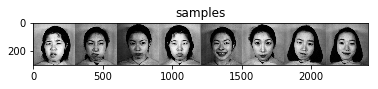

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title='samples')

Training the model
------------------

In [4]:
from tqdm import tqdm

def train_model(model, criterion, optimizer, scheduler, writer=None, i=0, dataloaders=None, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    
                    if isinstance(outputs, tuple):
                        outputs=outputs[0]
                    
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            

            writer.add_scalar(phase+"/loss", epoch_loss, epoch)
            writer.add_scalar(phase+"/acc", epoch_acc, epoch)


            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), 'saved/inception_'+str(i)+'.pt')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_acc

Visualizing the model predictions

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [5]:
accuracies = []
index = list(np.random.permutation(213))

for i in range(10):
    idx = {'val': index[22*i:22*(i+1)], 'train': index[:i*22]+index[((i+1)*22) -1:]}
    dataloaders = {x: torch.utils.data.DataLoader(KDEFDataset(transforms_=data_transforms[x], idx=idx[x]), batch_size=22,
                                             shuffle=True)
              for x in ['train', 'val']}
    
    model_ft = models.inception_v3(pretrained=True)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, class_names)

    model_ft = model_ft.to(device)

    criterion = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=4, gamma=0.1)

    writer = SummaryWriter('./logs/inception_full')

    model_ft, best_acc  = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, writer, i, dataloaders,
                           num_epochs=20)
    
    
    accuracies.append(float(best_acc.data[0].cpu().numpy()))
    print("\n\n\n------------------------------------\n Accuracies ", accuracies)
    print("\n\n")

Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:05<00:00,  1.57it/s]


train Loss: 1.9509 Acc: 0.1927


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.60it/s]


val Loss: 1.9319 Acc: 0.0909

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  1.91it/s]


train Loss: 1.7022 Acc: 0.3750


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.34it/s]


val Loss: 1.8043 Acc: 0.2273

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  1.89it/s]


train Loss: 1.1523 Acc: 0.6823


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.64it/s]


val Loss: 1.1235 Acc: 0.6818

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  1.93it/s]


train Loss: 0.6278 Acc: 0.8542


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.30it/s]


val Loss: 1.0290 Acc: 0.6818

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  1.91it/s]


train Loss: 0.2863 Acc: 0.9688


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.60it/s]


val Loss: 0.5612 Acc: 0.9091

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  1.92it/s]


train Loss: 0.2163 Acc: 0.9635


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.56it/s]


val Loss: 0.4065 Acc: 0.9091

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  1.90it/s]


train Loss: 0.2207 Acc: 0.9740


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.30it/s]


val Loss: 0.3719 Acc: 0.8636

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  1.92it/s]


train Loss: 0.2037 Acc: 0.9688


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.42it/s]


val Loss: 0.3555 Acc: 0.8636

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  1.92it/s]


train Loss: 0.1637 Acc: 0.9896


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.34it/s]


val Loss: 0.3693 Acc: 0.8636

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  1.90it/s]


train Loss: 0.1346 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


val Loss: 0.3370 Acc: 0.9091

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  1.91it/s]


train Loss: 0.1437 Acc: 0.9896


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.50it/s]


val Loss: 0.3352 Acc: 0.8636

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  1.91it/s]


train Loss: 0.1263 Acc: 0.9948


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.34it/s]


val Loss: 0.3185 Acc: 0.9091

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  1.92it/s]


train Loss: 0.1306 Acc: 0.9948


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.58it/s]


val Loss: 0.3472 Acc: 0.8636

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  1.89it/s]


train Loss: 0.1235 Acc: 0.9948


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.56it/s]


val Loss: 0.3446 Acc: 0.8636

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  1.91it/s]


train Loss: 0.1125 Acc: 0.9948


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.44it/s]


val Loss: 0.3328 Acc: 0.8636

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  1.89it/s]


train Loss: 0.1421 Acc: 0.9896


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.56it/s]


val Loss: 0.3205 Acc: 0.9091

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  1.92it/s]


train Loss: 0.1265 Acc: 0.9948


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.50it/s]


val Loss: 0.3155 Acc: 0.9091

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  1.91it/s]


train Loss: 0.1268 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.44it/s]


val Loss: 0.3353 Acc: 0.8636

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  1.92it/s]


train Loss: 0.1583 Acc: 0.9896


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.23it/s]


val Loss: 0.3353 Acc: 0.8636

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  1.92it/s]


train Loss: 0.1667 Acc: 0.9896


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.69it/s]


val Loss: 0.3356 Acc: 0.9091

Training complete in 1m 41s
Best val Acc: 0.909091


C:\Users\bikas\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number





------------------------------------
 Accuracies  [0.9090909090909092]



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  1.89it/s]


train Loss: 1.9995 Acc: 0.1302


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.38it/s]


val Loss: 1.8663 Acc: 0.3636

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  1.89it/s]


train Loss: 1.7684 Acc: 0.3646


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.66it/s]


val Loss: 1.7274 Acc: 0.2727

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  1.87it/s]


train Loss: 1.1787 Acc: 0.6927


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s]


val Loss: 1.2586 Acc: 0.5000

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  1.90it/s]


train Loss: 0.5629 Acc: 0.8750


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s]


val Loss: 1.0271 Acc: 0.6818

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  1.90it/s]


train Loss: 0.2769 Acc: 0.9635


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.87it/s]


val Loss: 0.7871 Acc: 0.7273

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  1.87it/s]


train Loss: 0.2730 Acc: 0.9479


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.32it/s]


val Loss: 0.6999 Acc: 0.7273

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  1.86it/s]


train Loss: 0.1829 Acc: 0.9896


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]


val Loss: 0.6733 Acc: 0.7273

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  1.86it/s]


train Loss: 0.2400 Acc: 0.9583


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


val Loss: 0.6536 Acc: 0.7273

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  1.89it/s]


train Loss: 0.1689 Acc: 0.9844


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


val Loss: 0.6630 Acc: 0.7273

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  1.89it/s]


train Loss: 0.1322 Acc: 0.9948


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.23it/s]


val Loss: 0.6669 Acc: 0.7273

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  1.88it/s]


train Loss: 0.1280 Acc: 0.9896


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.73it/s]


val Loss: 0.6637 Acc: 0.7273

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  1.87it/s]


train Loss: 0.1734 Acc: 0.9844


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.60it/s]


val Loss: 0.6319 Acc: 0.7727

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  1.88it/s]


train Loss: 0.1432 Acc: 0.9844


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.54it/s]


val Loss: 0.6450 Acc: 0.7273

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  1.89it/s]


train Loss: 0.1477 Acc: 0.9844


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.58it/s]


val Loss: 0.6531 Acc: 0.7727

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  1.90it/s]


train Loss: 0.1669 Acc: 0.9792


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.25it/s]


val Loss: 0.6541 Acc: 0.7273

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  1.89it/s]


train Loss: 0.1393 Acc: 0.9948


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.66it/s]


val Loss: 0.6413 Acc: 0.7273

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  1.89it/s]


train Loss: 0.1488 Acc: 0.9948


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


val Loss: 0.6414 Acc: 0.7273

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  1.89it/s]


train Loss: 0.1489 Acc: 0.9896


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.01it/s]


val Loss: 0.6530 Acc: 0.7273

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  1.89it/s]


train Loss: 0.1507 Acc: 0.9948


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.42it/s]


val Loss: 0.6655 Acc: 0.7273

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  1.89it/s]


train Loss: 0.1397 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.50it/s]


val Loss: 0.6601 Acc: 0.7273

Training complete in 1m 41s
Best val Acc: 0.772727



------------------------------------
 Accuracies  [0.9090909090909092, 0.7727272727272727]





KeyboardInterrupt: 